In [1]:
##imports and setup
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, NumpyArrayIterator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model
import cv2 as cv
import keras
from keras.applications import resnet_v2
from keras.models import Model

#mount drive:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
def add_top_layer(model_base,output_classes):
  bottom_model = model_base.output
  """creates the top or head of the model that will be 
  placed ontop of the bottom layers"""
  bottom_model = Flatten(name="flatten")(bottom_model)
  bottom_model = Dense(1024,activation='relu')(bottom_model)
  bottom_model = Dropout(0.50)(bottom_model)
  bottom_model = Dense(1024,activation='relu')(bottom_model)
  bottom_model = Dropout(0.50)(bottom_model)
  bottom_model = Dense(512,activation='relu')(bottom_model)
  bottom_model = Dropout(0.50)(bottom_model)
  bottom_model = Dense(output_classes,activation='sigmoid')(bottom_model)

  return bottom_model
  #print(model.summary())
print('completed')


completed


In [ ]:
IMG_SIZE = 128
IMG_DIM = 3
model_base=resnet_v2.ResNet50V2(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,IMG_DIM))
#loading the pretrained network.

#print(model.summary())
#Keeping the weights from the trained network.
for layers in model_base.layers:
  layers.trainable = False
## adding the regression layer on top
model_head=add_top_layer(model_base,2)
#Connecting the two models
model=Model(inputs=model_base.input,outputs=model_head)
keras.backend.set_epsilon(1) #Used for mape
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(optimizer=opt, loss='MSE', metrics=['mse', 'mape'])
#print(model.summary())
print('completed')

94674944/94668760 [==============================] - 1s 0us/step
completed


In [3]:

# Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/Colab/emotic'


# Load training preprocessed data
train_body = np.load(data_src+'/train_body_arr.npy')
train_cont = np.load(data_src+'/train_cont_arr.npy')[:,:2]/10

# Load validation preprocessed data 
val_body = np.load(data_src+'/val_body_arr.npy')
val_cont = np.load(data_src+'/val_cont_arr.npy')[:,:2]/10

# Load testing preprocessed data
test_body = np.load(data_src+'/test_body_arr.npy')
test_cont = np.load(data_src+'/test_cont_arr.npy')[:,:2]/10

body = np.append(train_body,val_body,axis=0)
cont = np.append(train_cont,val_cont,axis=0)

print(body.shape)
print(cont.shape)
print('completed')

(26581, 128, 128, 3)
(26581, 2)
completed


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


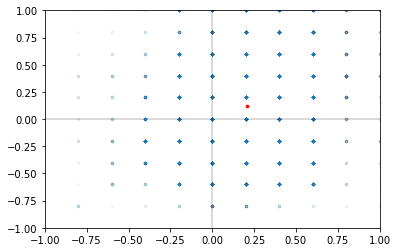

In [15]:
#dataset investigation
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.axhline(y=0, color='k',linewidth=0.3)
ax.axvline(x=0, color='k',linewidth=0.3)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.scatter(cont[:,0]*2-1,cont[:,1]*2-1,s=7,alpha=0.01)
ax.scatter(np.mean(cont[:,0])*2-1,np.mean(cont[:,1])*2-1,s=7,c=(1,0,0))
fig.show()
#print(np.mean(train_cont[:,0]))
#print(np.mean(train_cont[:,1]))

In [ ]:
## Putting the data into training classes:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(body, cont, test_size=0.20, shuffle= True)
body=None
cont=None
##Try it out with a larger batch size
batch_size=64
#### Fit the dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

training_set=train_datagen.flow(x_train,y_train,batch_size=batch_size)


val_datagen = ImageDataGenerator(rescale=1./255,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

val_set=val_datagen.flow(x_valid,y_valid,batch_size=batch_size)

print('completed')

completed


In [ ]:
###making the training ready
PATH="/content/drive/MyDrive/Colab/emotic/"
chk_path = PATH+'model_resnet_emotic.h5'
log_dir = PATH+"checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                               save_best_only=True,
                               verbose=1,
                               mode='min',
                               moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=3,
                            verbose=1,
                            restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=6,
                                verbose=1,
                                min_delta=0.0001)

steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = val_set.n // val_set.batch_size

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger(PATH+'training.log')

callback = [checkpoint, reduce_lr, csv_logger]
print(steps_per_epoch)
print(validation_steps)

print('completed')

332
83
completed


In [ ]:
with tf.device('/device:GPU:0'):
  epochs=40
  model_hist = model.fit(x=training_set,
                  validation_data=val_set,
                  epochs=epochs,
                  callbacks=callback,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)
save_path = PATH+'model_resnet_emotic_finished.h5'
model.save_weights(save_path)

Epoch 1/40
332/332 [==============================] - 133s 293ms/step - loss: 0.1330 - mse: 0.1330 - mape: 30.8420 - val_loss: 0.0284 - val_mse: 0.0284 - val_mape: 13.3520

Epoch 00001: val_loss improved from inf to 0.02836, saving model to /content/drive/MyDrive/Colab/emotic/model_resnet_emotic.h5
Epoch 2/40
332/332 [==============================] - 97s 292ms/step - loss: 0.0325 - mse: 0.0325 - mape: 14.3176 - val_loss: 0.0277 - val_mse: 0.0277 - val_mape: 13.1764

Epoch 00002: val_loss improved from 0.02836 to 0.02773, saving model to /content/drive/MyDrive/Colab/emotic/model_resnet_emotic.h5
Epoch 3/40
332/332 [==============================] - 97s 291ms/step - loss: 0.0292 - mse: 0.0292 - mape: 13.5101 - val_loss: 0.0274 - val_mse: 0.0274 - val_mape: 13.0568

Epoch 00003: val_loss improved from 0.02773 to 0.02738, saving model to /content/drive/MyDrive/Colab/emotic/model_resnet_emotic.h5
Epoch 4/40
332/332 [==============================] - 96s 290ms/step - loss: 0.0283 - mse: 0.0

KeyboardInterrupt: ignored